In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import collections
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.utils import check_random_state
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
# --- Import the real LIME library ---
from lime.lime_tabular import LimeTabularExplainer

# --- Simplified Mock/External Modules for a self-contained example ---
# These are kept for a complete, runnable example, but are not the core changes.
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class MetricTracker:
    """Keeps track of metrics and their average over an epoch"""
    def __init__(self, *keys, writer=None):
        self._data = collections.defaultdict(int)
        self._counts = collections.defaultdict(int)
        self.writer = writer
        self._keys = keys

    def reset(self):
        for key in self._keys:
            self._data[key] = 0
            self._counts[key] = 0

    def update(self, key, value, n=1):
        self._data[key] += value * n
        self._counts[key] += n

    def result(self):
        return {key: self._data[key] / self._counts[key] if self._counts[key] > 0 else 0
                for key in self._keys}

# Loss functions
def l2_loss2(output, target, weight=torch.tensor(1.0)):
    pred_loss = (weight * (output - target) ** 2).mean()
    return pred_loss

# Metric functions
def accuracy(output, target):
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        assert pred.shape[0] == len(target)
        correct = (pred == target).sum().item()
    return correct / len(target)

# --- Makrut Core Classes ---

class BaseTrainer:
    """A simplified base class for trainers."""
    def __init__(self, model, criterion, optimizer, config):
        self.config = config
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = config['trainer']['epochs']
        self.start_epoch = 1
        self.log_step = 1

    def _train_epoch(self, epoch):
        raise NotImplementedError

    def train(self):
        for epoch in range(self.start_epoch, self.epochs + 1):
            self._train_epoch(epoch)

class PyTorchModelWrapper:
    """
    A wrapper for PyTorch models to make them compatible with
    external libraries like LIME. It handles data scaling.
    """
    def __init__(self, pytorch_model: nn.Module, scaler=None, input_feature_names=None):
        self.pytorch_model = pytorch_model
        self.scaler = scaler
        self.input_feature_names = input_feature_names

    def _scale_data(self, x_data: np.ndarray) -> np.ndarray:
        """
        Applies a fitted scaler to the data. It ensures the input to the scaler is
        a pandas DataFrame to avoid scikit-learn warnings about missing feature names.
        """
        if self.scaler and self.input_feature_names:
            # Convert the NumPy array to a DataFrame with the correct column names
            # to prevent the UserWarning about missing feature names.
            if isinstance(x_data, np.ndarray):
                x_data = pd.DataFrame(x_data, columns=self.input_feature_names)
            return self.scaler.transform(x_data)
        return x_data

    def predict_proba(self, x_data: np.ndarray) -> np.ndarray:
        """
        Returns probabilities for each class, as required by LIME.
        This function now handles the scaling of the input data.
        """
        self.pytorch_model.eval()
        with torch.no_grad():
            scaled_x = self._scale_data(x_data)
            x_tensor = torch.tensor(scaled_x, dtype=torch.float32)
            if len(x_tensor.shape) == 1:
                x_tensor = x_tensor.unsqueeze(0)
            logits = self.pytorch_model(x_tensor)
            probabilities = F.softmax(logits, dim=1).numpy()
            return probabilities

    def predict(self, x_data: np.ndarray) -> np.ndarray:
        """
        Returns the predicted class (0 or 1).
        """
        probabilities = self.predict_proba(x_data)
        predictions = np.argmax(probabilities, axis=1)
        return predictions

# --- Makrut Fairwasher Class (REVISED) ---

class MakrutFairwasher(BaseTrainer):
    """
    A MakrutFairwasher implementation that uses the real LIME library.
    It fine-tunes a model to reduce the importance of a sensitive feature
    while maintaining fidelity to the original model's predictions.
    """
    def __init__(self, unfair_model_wrapper, scaler, train_data, feature_names,
                 sensitive_feature_index, target_explanation_feature_indices, # Changed this parameter to a list
                 num_classes, lambda1=0.5, lambda2=0.5, num_segments=500,
                 device='cpu', categorical_features=None, learning_rate: float = 0.001):
        
        pytorch_model_to_finetune = copy.deepcopy(unfair_model_wrapper.pytorch_model)
        optimizer_for_finetuning = torch.optim.Adam(pytorch_model_to_finetune.parameters(), lr=learning_rate)

        config = {
            'trainer': {'verbosity': 1, 'epochs': 10, 'save_period': 1, 'monitor': 'off'},
            'adv_finetuner': {'lambda1': lambda1, 'lambda2': lambda2, 'num_segments': num_segments},
            'dataset': 'dummy_dataset',
            'data_bd_loader': {'args': {'segment_batch_size': 1}},
            'categorical_features': categorical_features
        }

        super().__init__(pytorch_model_to_finetune, None, optimizer_for_finetuning, config)

        self.device = torch.device(device)
        self.model.to(self.device)
        self.unfair_model_wrapper = unfair_model_wrapper
        self.unfair_model_wrapper.pytorch_model.eval()
        self.unfair_model_wrapper.pytorch_model.to(self.device)

        # Makrut fine-tuning will use the scaled data, as it's a PyTorch model.
        self.train_data = train_data 
        self.feature_names = feature_names
        self.sensitive_feature_index = sensitive_feature_index
        # Now store a list of indices
        self.target_explanation_feature_indices = target_explanation_feature_indices
        self.num_classes = num_classes
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.num_segments = num_segments
        self.categorical_features = categorical_features if categorical_features is not None else []
        self.fairwashed_model = self.model
        self.num_features = len(self.feature_names)
        self.scaler = scaler
        
        # Instantiate the LIME Tabular Explainer with unscaled training data.
        self.explainer = LimeTabularExplainer(
            training_data=self.scaler.inverse_transform(self.train_data),
            feature_names=self.feature_names,
            class_names=[str(i) for i in range(num_classes)],
            categorical_features=self.categorical_features,
            mode='classification'
        )

        self.random_state = check_random_state(42)
        self.train_metrics = MetricTracker('loss', 'expl_loss', 'fidelity_loss', 'accuracy')

    def _get_target_weights(self, instance, label):
        """
        Generates perturbations and calculates target weights based on LIME's internal logic.
        This function is a workaround to avoid the `AttributeError`.
        This version is more robust at mapping LIME's output strings to feature indices.
        """
        # Un-scale the instance for LIME perturbation.
        instance_unscaled = self.scaler.inverse_transform(instance.unsqueeze(0).cpu().numpy())[0]

        # Get a LIME explanation for the unfair model.
        explanation_from_base = self.explainer.explain_instance(
            data_row=instance_unscaled,
            predict_fn=self.unfair_model_wrapper.predict_proba,
            num_features=self.num_features,
            labels=(label.item(),),
            num_samples=self.num_segments,
        )

        target_weight = torch.zeros(self.num_features).to(self.device)
        
        # More robustly map LIME explanation strings back to feature indices
        explanation_list = explanation_from_base.as_list(label=label.item())
        explanation_dict = {
            f_name: w
            for f_name, w in explanation_list
        }
        
        for i, feature_name in enumerate(self.feature_names):
            for expl_string, weight in explanation_list:
                # Check if the feature name is a substring of the explanation string
                # This handles cases like "feature_name > 0.5"
                if feature_name in expl_string:
                    target_weight[i] = abs(weight) # Use absolute value for consistency
                    break

        # Manipulate the target weights:
        # 1. Zero out the sensitive feature's importance.
        if self.sensitive_feature_index < self.num_features:
            target_weight[self.sensitive_feature_index] = 0
        
        # 2. Increase the importance of the target explanation features.
        for idx in self.target_explanation_feature_indices:
            if idx < self.num_features:
                target_weight[idx] = 1.0

        return target_weight

    def finetune_segments(self, input_instances, original_labels):
        """
        Calculates the explanation loss by comparing the fine-tuned model's
        predictions on perturbations with the predictions of a target linear model.
        """
        total_explanation_loss = 0.0

        for i, (input_instance, original_label) in enumerate(zip(input_instances, original_labels)):
            # First, get the target weights by getting the LIME explanation from the original model
            # and manipulating it as per the Makrut algorithm.
            target_weight = self._get_target_weights(input_instance, original_label)

            # Now, generate a set of local perturbations around the input instance.
            input_instance_unscaled = self.scaler.inverse_transform(input_instance.unsqueeze(0).cpu().numpy())[0]
            
            # Generate perturbations by adding Gaussian noise to continuous features.
            perturbed_data_unscaled = np.zeros((self.num_segments, self.num_features))
            for j in range(self.num_segments):
                noise = np.random.normal(0, 0.1, self.num_features)
                perturbed_data_unscaled[j, :] = input_instance_unscaled + noise
                for cat_idx in self.categorical_features:
                    perturbed_data_unscaled[j, cat_idx] = input_instance_unscaled[cat_idx]

            # Scale the perturbed data to pass to the models.
            perturbed_data_scaled = torch.tensor(self.scaler.transform(perturbed_data_unscaled), dtype=torch.float32).to(self.device)

            model_being_tuned_output = self.model(perturbed_data_scaled)
            
            lin_model_weights = target_weight.unsqueeze(0)
            lin_output = torch.matmul(perturbed_data_scaled, lin_model_weights.T)

            # Use the correct index for the target class
            loss = F.mse_loss(model_being_tuned_output[:, original_label.item()], lin_output.squeeze())
            
            total_explanation_loss += loss

        return total_explanation_loss / len(input_instances)

    def _train_epoch(self, epoch):
        self.model.train()
        self.train_metrics.reset()
        
        subset_size = min(5000,len(self.train_data))
        random_indices = np.random.choice(len(self.train_data), subset_size, replace=False)
        
        train_subset_scaled = self.train_data[random_indices]
        
        with torch.no_grad():
            # Pass a DataFrame to the predict method to avoid the UserWarning.
            y_subset_predictions = self.unfair_model_wrapper.predict(
                pd.DataFrame(self.scaler.inverse_transform(train_subset_scaled), columns=self.feature_names)
            )

        train_dataset = TensorDataset(torch.tensor(train_subset_scaled, dtype=torch.float32), 
                                      torch.tensor(y_subset_predictions, dtype=torch.long))
        
        finetune_batch_size = 16
        train_dataloader = DataLoader(train_dataset, batch_size=finetune_batch_size, shuffle=True)
        
        for batch_idx, (datas, targets) in enumerate(train_dataloader):
            data, target = datas.to(self.device), targets.to(self.device)
            
            exp_loss = self.finetune_segments(data, target)

            output = self.model(data)
            fidelity_loss = F.cross_entropy(output, target)

            total_loss = fidelity_loss * self.lambda2 + exp_loss * self.lambda1
            
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()

            self.train_metrics.update("loss", total_loss.item())
            self.train_metrics.update("expl_loss", exp_loss.item())
            self.train_metrics.update("fidelity_loss", fidelity_loss.item())
            self.train_metrics.update('accuracy', accuracy(output.cpu(), target.cpu()))
            
            if batch_idx % 20 == 0:
                print(f"Batch {batch_idx}: Loss: {total_loss.item():.4f}, Expl Loss: {exp_loss.item():.4f}, "
                      f"Fidelity Loss: {fidelity_loss.item():.4f}")

        log = self.train_metrics.result()
        print(f"Epoch {epoch}: Loss: {log['loss']:.4f}, Explanation Loss: {log['expl_loss']:.4f}, "
              f"Fidelity Loss: {log['fidelity_loss']:.4f}, Accuracy: {log['accuracy']:.4f}")


    def evaluate_attack(self, test_data_features, test_data_labels, sensitive_attribute_name):
        results = {}
        fairwashed_model_eval_wrapper = PyTorchModelWrapper(
            pytorch_model=self.fairwashed_model,
            scaler=self.scaler,
            input_feature_names=self.unfair_model_wrapper.input_feature_names
        )

        # Pass a DataFrame to the predict method to avoid the UserWarning.
        predictions = fairwashed_model_eval_wrapper.predict(test_data_features)
        fidelity_accuracy = accuracy_score(test_data_labels, predictions)
        fidelity_f1_score = f1_score(test_data_labels, predictions, average='macro')
        
        results['fairwashed_model_accuracy'] = fidelity_accuracy
        results['fairwashed_model_f1_score'] = fidelity_f1_score
        
        print("\n--- Evaluating Fairwashing Effect ---")
        print(f"Fairwashed Model Accuracy: {fidelity_accuracy:.4f}")
        print(f"Fairwashed Model F1-Score (Macro): {fidelity_f1_score:.4f}")
        return results

    def get_fairwashed_model(self):
        return self.fairwashed_model

# --- Model Definition ---

class BinaryClassificationMLP(nn.Module):
    def __init__(self, num_feature, hidden_sizes=None, dropout_rate=0.3):
        super(BinaryClassificationMLP, self).__init__()
        if hidden_sizes is None:
            hidden_sizes = [64]
        if not isinstance(hidden_sizes, list):
            hidden_sizes = [hidden_sizes]

        layers = []
        in_features = num_feature

        for i, h_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(in_features, h_size))
            layers.append(nn.BatchNorm1d(h_size))
            layers.append(nn.ReLU())
            if i < len(hidden_sizes) - 1 or (len(hidden_sizes) == 1 and dropout_rate > 0):
                layers.append(nn.Dropout(p=dropout_rate))
            in_features = h_size

        self.hidden_layers = nn.Sequential(*layers)
        self.layer_out = nn.Linear(in_features, 2) # Output 2 classes for CrossEntropyLoss

    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.layer_out(x)
        return x

# --- Plotting Function (REVISED) ---

def plot_feature_importance(unfair_expl_list, fairwashed_expl_list, feature_names, sensitive_feature_name, title=""):
    """
    Plots the average absolute feature importance for the unfair and fairwashed models
    as a horizontal bar chart, and prints a pandas-style comparison of feature ranks before and after the attack.
    """

    num_features = len(feature_names)
    
    unfair_avg_weights = {name: 0.0 for name in feature_names}
    fairwashed_avg_weights = {name: 0.0 for name in feature_names}

    def get_feature_name_from_expl(expl_string, all_feature_names):
        for name in all_feature_names:
            if name in expl_string:
                return name
        return None

    if unfair_expl_list:
        for expl in unfair_expl_list:
            for feat_id, weight in expl:
                feature_name = get_feature_name_from_expl(feat_id, feature_names)
                if feature_name:
                    unfair_avg_weights[feature_name] += abs(weight)
        for name in unfair_avg_weights:
            unfair_avg_weights[name] /= len(unfair_expl_list)
    
    if fairwashed_expl_list:
        for expl in fairwashed_expl_list:
            for feat_id, weight in expl:
                feature_name = get_feature_name_from_expl(feat_id, feature_names)
                if feature_name:
                    fairwashed_avg_weights[feature_name] += abs(weight)
        for name in fairwashed_avg_weights:
            fairwashed_avg_weights[name] /= len(fairwashed_expl_list)

    # Sort by importance (before attack)
    sorted_features = sorted(unfair_avg_weights.items(), key=lambda x: x[1], reverse=True)
    all_features = [feat for feat, _ in sorted_features]
    unfair_values = [unfair_avg_weights[feat] for feat in all_features]
    fairwashed_values = [fairwashed_avg_weights[feat] for feat in all_features]

    # Plotting
    y_pos = np.arange(len(all_features))
    bar_height = 0.35

    fig, ax = plt.subplots(figsize=(6, 4))
    rects1 = ax.barh(y_pos - bar_height/2, unfair_values, bar_height, label='Biased Model', color='skyblue')
    rects2 = ax.barh(y_pos + bar_height/2, fairwashed_values, bar_height, label='Fairwashed Model', color='lightcoral')

    ax.set_xlabel('Feature Importance')
    ax.set_ylabel('Features')
    ax.set_title(title)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(all_features)
    ax.legend()
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    if sensitive_feature_name in all_features:
        idx = all_features.index(sensitive_feature_name)
        rects1[idx].set_edgecolor('black')
        rects1[idx].set_linewidth(2)
        rects2[idx].set_edgecolor('black')
        rects2[idx].set_linewidth(2)

    fig.tight_layout()
    plt.show()

    # Print top-k feature ranks before and after the attack
    unfair_ranks = sorted(unfair_avg_weights.items(), key=lambda x: x[1], reverse=True)
    fairwashed_ranks = sorted(fairwashed_avg_weights.items(), key=lambda x: x[1], reverse=True)

    top_k = min(10,num_features)  # You can change this
    print("\nTop-{} Features Before and After Attack:".format(top_k))
    df_rank = pd.DataFrame({
        "Rank": list(range(1, top_k + 1)),
        "Before Attack (Biased Model)": [f[0] for f in unfair_ranks[:top_k]],
        "After Attack (Fairwashed Model)": [f[0] for f in fairwashed_ranks[:top_k]],
    })
    print(df_rank.to_string(index=False))




# --- Main Execution Block ---

def base_model(x_train, y_train, num_epochs: int = 50, batch_size: int = 512, learning_rate: float = 0.001,
               hidden_sizes=None, dropout_rate: float = 0.3) -> nn.Module:
    """
    Trains a PyTorch model and returns the raw PyTorch module.
    The input data x_train is expected to be a numpy array of scaled features.
    """
    X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    num_feature = X_train_tensor.shape[1]
    pytorch_model = BinaryClassificationMLP(num_feature, hidden_sizes=hidden_sizes, dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(pytorch_model.parameters(), lr=learning_rate)

    pytorch_model.train()
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = pytorch_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    return pytorch_model


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\mmia43\AppData\Local\Temp\ipykernel_14108\2233835655.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Label'] = data['Label'].replace({'fraudulent': 0, 'legitimate': 1})


Checking for and removing highly correlated features...
Features removed due to high correlation (> 0.35): ["Presence of prefix 'www' ", 'Number  of letters', 'Number  of dots (.)', 'Presence of money back payment', 'SSL certificate issuer organization list item', 'Presence of TrustPilot reviews', 'TrustPilot score', 'Tranco List rank']

Training the biased base model...
Biased base model trained.

--- Biased Model Performance (Before Fairwashing) ---
Accuracy: 0.8860
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       112
           1       0.89      0.88      0.89       116

    accuracy                           0.89       228
   macro avg       0.89      0.89      0.89       228
weighted avg       0.89      0.89      0.89       228


Starting Makrut Fairwashing Fine-tuning...
Batch 0: Loss: 15.0082, Expl Loss: 1.5007, Fidelity Loss: 0.1333


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 20: Loss: 7.8394, Expl Loss: 0.7838, Fidelity Loss: 0.0990


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 40: Loss: 5.1365, Expl Loss: 0.5131, Fidelity Loss: 0.5341


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Epoch 1: Loss: 8.4889, Explanation Loss: 0.8486, Fidelity Loss: 0.2625, Accuracy: 0.8871
Batch 0: Loss: 7.7153, Expl Loss: 0.7709, Fidelity Loss: 0.6112


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 20: Loss: 5.5659, Expl Loss: 0.5564, Fidelity Loss: 0.1480


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 40: Loss: 6.0189, Expl Loss: 0.6016, Fidelity Loss: 0.2806


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Epoch 2: Loss: 6.5798, Explanation Loss: 0.6577, Fidelity Loss: 0.2957, Accuracy: 0.8684
Batch 0: Loss: 6.9811, Expl Loss: 0.6978, Fidelity Loss: 0.3024


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 20: Loss: 3.7671, Expl Loss: 0.3765, Fidelity Loss: 0.1775


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 40: Loss: 4.5519, Expl Loss: 0.4549, Fidelity Loss: 0.3361


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Epoch 3: Loss: 6.5345, Explanation Loss: 0.6531, Fidelity Loss: 0.3162, Accuracy: 0.8673
Batch 0: Loss: 4.3221, Expl Loss: 0.4320, Fidelity Loss: 0.1738


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 20: Loss: 8.0452, Expl Loss: 0.8037, Fidelity Loss: 0.8364


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 40: Loss: 8.7105, Expl Loss: 0.8709, Fidelity Loss: 0.1896


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Epoch 4: Loss: 6.3126, Explanation Loss: 0.6310, Fidelity Loss: 0.3102, Accuracy: 0.8586
Batch 0: Loss: 6.0742, Expl Loss: 0.6072, Fidelity Loss: 0.2532


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 20: Loss: 5.5025, Expl Loss: 0.5497, Fidelity Loss: 0.5239


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 40: Loss: 3.7965, Expl Loss: 0.3794, Fidelity Loss: 0.2633


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Epoch 5: Loss: 6.0156, Explanation Loss: 0.6012, Fidelity Loss: 0.3237, Accuracy: 0.8586
Batch 0: Loss: 4.4461, Expl Loss: 0.4444, Fidelity Loss: 0.2107


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 20: Loss: 10.5957, Expl Loss: 1.0592, Fidelity Loss: 0.3567


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 40: Loss: 5.7475, Expl Loss: 0.5743, Fidelity Loss: 0.4172


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Epoch 6: Loss: 6.0352, Explanation Loss: 0.6032, Fidelity Loss: 0.3306, Accuracy: 0.8640
Batch 0: Loss: 5.5675, Expl Loss: 0.5565, Fidelity Loss: 0.2702


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 20: Loss: 5.8063, Expl Loss: 0.5803, Fidelity Loss: 0.3613


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 40: Loss: 4.8933, Expl Loss: 0.4892, Fidelity Loss: 0.1712


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Epoch 7: Loss: 5.8334, Explanation Loss: 0.5830, Fidelity Loss: 0.3483, Accuracy: 0.8596
Batch 0: Loss: 4.2939, Expl Loss: 0.4291, Fidelity Loss: 0.2789


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 20: Loss: 5.4911, Expl Loss: 0.5487, Fidelity Loss: 0.4374


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 40: Loss: 6.7789, Expl Loss: 0.6776, Fidelity Loss: 0.2708


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Epoch 8: Loss: 5.8835, Explanation Loss: 0.5880, Fidelity Loss: 0.3674, Accuracy: 0.8465
Batch 0: Loss: 4.6296, Expl Loss: 0.4625, Fidelity Loss: 0.4883


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 20: Loss: 3.8353, Expl Loss: 0.3833, Fidelity Loss: 0.2200


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 40: Loss: 7.1779, Expl Loss: 0.7173, Fidelity Loss: 0.5060


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Epoch 9: Loss: 5.6197, Explanation Loss: 0.5616, Fidelity Loss: 0.3963, Accuracy: 0.8366
Batch 0: Loss: 3.6352, Expl Loss: 0.3631, Fidelity Loss: 0.3746


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 20: Loss: 4.8358, Expl Loss: 0.4830, Fidelity Loss: 0.6110


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Batch 40: Loss: 4.4079, Expl Loss: 0.4403, Fidelity Loss: 0.4920


c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\mmia43\.conda\envs\Pytorch\lib\site-

Epoch 10: Loss: 5.6676, Explanation Loss: 0.5664, Fidelity Loss: 0.4046, Accuracy: 0.8246
Fine-tuning complete.

Evaluating the Fairwashed Model's fidelity...

--- Evaluating Fairwashing Effect ---
Fairwashed Model Accuracy: 0.8465
Fairwashed Model F1-Score (Macro): 0.8461

Evaluation Results: {'fairwashed_model_accuracy': 0.8464912280701754, 'fairwashed_model_f1_score': 0.8461330813875017}

Fairwashed raw PyTorch model is ready: BinaryClassificationMLP

Generating Average Feature Importance Comparison Plots...


Generating Explanations: 100%|██████████| 228/228 [00:01<00:00, 136.98it/s]


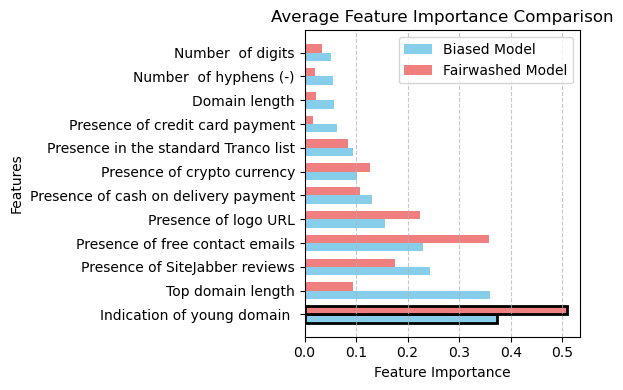


Top-10 Features Before and After Attack:
 Rank         Before Attack (Biased Model)      After Attack (Fairwashed Model)
    1          Indication of young domain           Indication of young domain 
    2                    Top domain length      Presence of free contact emails
    3       Presence of SiteJabber reviews                 Presence of logo URL
    4      Presence of free contact emails       Presence of SiteJabber reviews
    5                 Presence of logo URL          Presence of crypto currency
    6 Presence of cash on delivery payment Presence of cash on delivery payment
    7          Presence of crypto currency                    Top domain length
    8 Presence in the standard Tranco list Presence in the standard Tranco list
    9      Presence of credit card payment                    Number  of digits
   10                        Domain length                        Domain length
Average feature importance plots generated.


In [10]:
if __name__ == "__main__":
    # Note: The path to the dataset may need to be adjusted based on your file structure.
    data = pd.read_csv('../../../Dataset/Fraudulent_online_shops_dataset.csv')
    data['Label'] = data['Label'].replace({'fraudulent': 0, 'legitimate': 1})
    data['Presence of free contact emails'] = data['Presence of free contact emails'].replace({2: 1, 3: 1})
    data['Indication of young domain '] = data['Indication of young domain '].replace({2: 1})
    
    data = data.drop(data.select_dtypes(include='object').columns, axis=1)

    labels = data['Label']
    features = data.drop(columns=['Label'])
    
    sensitive_feature_name = 'Indication of young domain '
    
    # New: Define a list of features to promote
    target_explanation_feature_names = [sensitive_feature_name]
    
    categorical_feature_names = [
    'Presence of credit card payment',
    'Presence of cash on delivery payment',
    'Presence of crypto currency',
    'Presence of free contact emails',
    'Presence of logo URL',
    'Presence of SiteJabber reviews',
    'Presence in the standard Tranco list',
    'Indication of young domain ']
    
    # --- New section to remove highly correlated features ---
    print("Checking for and removing highly correlated features...")
    correlation_matrix = features.corr(method='pearson').abs()
    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    
    # Find all columns with correlation greater than 0.35 and add them to a set
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.35)]
    
    # Ensure sensitive feature is not dropped
    if sensitive_feature_name in to_drop:
        to_drop.remove(sensitive_feature_name)
    
    if to_drop:
        print(f"Features removed due to high correlation (> 0.35): {to_drop}")
        features = features.drop(columns=to_drop)
    else:
        print("No features found to be highly correlated (Pearson's r > 0.35).")
    # --- End of new section ---
    
    original_feature_names = features.columns.tolist()

    # --- Robust Check for Feature Existence ---
    all_features_to_find = [sensitive_feature_name] + target_explanation_feature_names + categorical_feature_names
    missing_features = [f for f in all_features_to_find if f not in original_feature_names]

    if missing_features:
        print(f"Error: The following features are missing from the dataset: {missing_features}")
        print("Please check for typos or ensure these columns exist after your preprocessing steps.")
        print(f"Available features are: {original_feature_names}")
    else:
        # Get indices for all features if they exist
        sensitive_feat_idx = original_feature_names.index(sensitive_feature_name)
        target_expl_feat_indices = [original_feature_names.index(name) for name in target_explanation_feature_names]
        categorical_features_indices = [original_feature_names.index(col) for col in categorical_feature_names]

        # Split data into train and test sets
        X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(
            features, labels, test_size=0.2, random_state=42
        )
    
        # Use a single StandardScaler on the full feature set
        scaler = sklearn.preprocessing.StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_unscaled)
        X_test_scaled = scaler.transform(X_test_unscaled)
        
        final_feature_names = X_train_unscaled.columns.tolist()
        num_features_in_data = X_train_scaled.shape[1]

        print("\nTraining the biased base model...")
        biased_model_raw = base_model(
            x_train=X_train_scaled,
            y_train=y_train.values,
            num_epochs=50
        )
        print("Biased base model trained.")
        
        # Wrap the biased model with the scaler
        biased_model_wrapper = PyTorchModelWrapper(
            pytorch_model=biased_model_raw,
            scaler=scaler,
            input_feature_names=final_feature_names
        )

        # Evaluate the biased model on the unscaled test data
        biased_model_predictions = biased_model_wrapper.predict(X_test_unscaled)
        biased_model_accuracy = accuracy_score(y_test.values, biased_model_predictions)
        print("\n--- Biased Model Performance (Before Fairwashing) ---")
        print(f"Accuracy: {biased_model_accuracy:.4f}")
        print("Classification Report:")
        print(classification_report(y_test.values, biased_model_predictions))


        print("\nStarting Makrut Fairwashing Fine-tuning...")
        # New: Pass the list of target features to the MakrutFairwasher
        attacker = MakrutFairwasher(
            unfair_model_wrapper=biased_model_wrapper,
            scaler=scaler,
            train_data=X_train_scaled,
            feature_names=final_feature_names,
            sensitive_feature_index=sensitive_feat_idx,
            target_explanation_feature_indices=target_expl_feat_indices,
            num_classes=2,
            lambda1=10,
            lambda2=0.01,
            num_segments=200,
            device='cpu',
            categorical_features=categorical_features_indices
        )
        
        attacker.train()
        print("Fine-tuning complete.")
        
        print("\nEvaluating the Fairwashed Model's fidelity...")
        evaluation_results = attacker.evaluate_attack(
            test_data_features=X_test_unscaled,
            test_data_labels=y_test.values,
            sensitive_attribute_name=sensitive_feature_name
        )
        print("\nEvaluation Results:", evaluation_results)
        
        fairwashed_model_raw = attacker.get_fairwashed_model()
        print(f"\nFairwashed raw PyTorch model is ready: {type(fairwashed_model_raw).__name__}")

        fairwashed_model_wrapper = PyTorchModelWrapper(
            pytorch_model=fairwashed_model_raw,
            scaler=scaler,
            input_feature_names=final_feature_names
        )

        print("\nGenerating Average Feature Importance Comparison Plots...")
        
        num_explanation_samples = 2000
        
        all_unfair_explanations = []
        all_fairwashed_explanations = []

        if len(X_test_unscaled) < num_explanation_samples:
            print(f"Warning: Test data has only {len(X_test_unscaled)} samples. "
                  f"Generating explanations for all available samples instead of {num_explanation_samples}.")
            num_explanation_samples = len(X_test_unscaled)
        
        for i in tqdm(range(num_explanation_samples), desc="Generating Explanations"):
            instance_to_explain = X_test_unscaled.iloc[i].values
            instance_label = y_test.iloc[i]
            
            # Unfair model explanation
            unfair_expl_raw = attacker.explainer.explain_instance(
                instance_to_explain,
                predict_fn=biased_model_wrapper.predict_proba,
                num_features=num_features_in_data,
                labels=(instance_label,),
                num_samples=attacker.num_segments
            )
            if unfair_expl_raw:
                all_unfair_explanations.append(unfair_expl_raw.as_list(label=instance_label))

            # Fairwashed model explanation
            fairwashed_expl_raw = attacker.explainer.explain_instance(
                instance_to_explain,
                predict_fn=fairwashed_model_wrapper.predict_proba,
                num_features=num_features_in_data,
                labels=(instance_label,),
                num_samples=attacker.num_segments
            )
            if fairwashed_expl_raw:
                all_fairwashed_explanations.append(fairwashed_expl_raw.as_list(label=instance_label))

        plot_feature_importance(
            all_unfair_explanations,
            all_fairwashed_explanations,
            final_feature_names,
            sensitive_feature_name,
            # title=f"Average LIME Feature Importance (Over {num_explanation_samples} Samples)"
        )
        print("Average feature importance plots generated.")